# 1. Data import and general preprocessing

### 1A. Import data

In [ ]:
import pandas as pd
import os

# Set directories
source_dir = ### Insert source directory ###

# Import Excel file
df = pd.read_excel(os.path.join(source_dir,'final_dataset.xlsx'))

# Drop category 2 (not sure), and 3 (not met)
df = df[(df['Group'] == 1) | (df['Group'] == 0)]
df.head(2)

### 1B. Remove uneccesary patterns

In [ ]:
import re

def preprocessor(text):
    # Remove newlines
    text = text.replace(r'\n', ' ')
    
    # Remove date
    date_pattern = r'[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,}'
    text = re.sub(date_pattern, ' ', text.lower())
    
    # Remove whitespace
    text = ' '.join(text.split())
    
    # Remove punctution, keep decimal points
    text = re.sub(r'[\W]+(?!\d)', ' ', text)
    
    # Remove the signature at the end of the report              
    
    if text.find(' i the teaching physician') != -1:
        body_pattern = re.compile(r'(.*) (?=i the teaching physician)')
        matched_text = body_pattern.search(text).group(1)
        
    elif text.find(' end of impression') != -1:
        body_pattern = re.compile(r'(.*) (?=end of impression)')
        matched_text = body_pattern.search(text).group(1)
    
    elif text.find(' radiologists signatures') != -1:
        body_pattern = re.compile(r'(.*) (?=radiologists signatures)')
        
        matched_text = body_pattern.search(text).group(1)
    
    else:
        matched_text = text
        
    return matched_text

df['cleaned_report'] = df['raw_report'].apply(preprocessor)
df.head(2)

### 1C. Remove stop words

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words_english = stopwords.words('english')

stop_words_modified = [w for w in stop_words_english if w not in ['no', 'not']]

def remove_words(clean_report): 
    clean_report_words = clean_report.split()
    stripped_report_words  = [word for word in clean_report_words if word.lower() not in stop_words_modified]
    stripped_report_text = ' '.join(stripped_report_words)
    return stripped_report_text

df['stripped_report'] = df['cleaned_report'].apply(remove_words)
df.head(2)

### 1D. Stemming

In [ ]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def porter_stemming(text):
    stemmed_report_words = [porter.stem(word) for word in text.split()]
    stemmed_report_text = ' '.join(stemmed_report_words)
    return stemmed_report_text

df['stemmed_report'] = df['stripped_report'].apply(porter_stemming)
df.head(2)

### 1E. Train Validation Test Split

In [ ]:
import pandas as pd
import os
import numpy as np

n_patients = len(df)

df = df.sample(frac = 1)

df['cohort'] = np.random.choice(['train','test'], size=n_patients, p=[0.8,.2])
df.head(2)

target_dir = ### Insert directory for preprocessed reports ###
df.to_excel(os.path.join(target_dir, 'preprocessed_reports.xlsx')) 

# 2. Preprocessing and hyperparameter tuning for all bag-of-words models

### 2A. Load Preprocessed Reports 

In [ ]:
import pandas as pd
import os

source_dir = ### Insert directory for preprocessed reports ###
df = pd.read_excel(os.path.join(source_dir, 'preprocessed_reports.xlsx')) 

df.head(2)

### 2B. Check Reports

In [ ]:
from numpy import asarray

df['raw_report'][2] #Example Report Raw
df['cleaned_report'][2] #Example Report Clean
df['stripped_report'][2] #Example Report Stripped
df['stemmed_report'][2] #Example Report Stemmed

### 2C. TFIDF-Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from numpy import asarray

word_vectorizer = TfidfVectorizer(
    ngram_range=(1,1),
    max_features=1000)
word_vectorizer.fit(df['stemmed_report'])
x_train = word_vectorizer.transform(df['stemmed_report'][(df['cohort'] == 'train')])
x_test = word_vectorizer.transform(df['stemmed_report'][(df['cohort'] == 'test')])
y_train = asarray(df['Group'][(df['cohort'] == 'train')])
y_test = asarray(df['Group'][(df['cohort'] == 'test')])

print('Shape x_train', x_train.shape)
print('Shape x_test', x_test.shape)
print('Shape y_train', y_train.shape)
print('Shape y_test', y_test.shape)

### 2D. Final logistic and LASSO regression models

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model
import numpy as np

cv_score_lr = np.mean(cross_val_score(
    LogisticRegression(C=0.1, solver='sag'), 
    x_train, y_train, cv=5, scoring='roc_auc'))

parameters = {"penalty":['l1','l2'],
             "C": [32, 16, 8, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01],
             "max_iter":[200]}

grid_search = GridSearchCV(LogisticRegression(), param_grid=parameters, scoring='neg_log_loss', cv=StratifiedKFold(5))
grid_search.fit(x_train, y_train)

best_params = grid_search.best_estimator_.get_params()
print(best_params)

cv_score_lasso = np.mean(cross_val_score(
    LogisticRegression(**best_params), 
    x_train, y_train, cv=5, scoring='roc_auc'))

model = LogisticRegression(C=0.1, solver='sag')
model.fit(x_train, y_train)

target_dir = ### Insert directory bag-of-words models ###
filename = 'logisticregression.sav'
pickle.dump(model, open(os.path.join(target_dir, filename), 'wb'))

model = LogisticRegression(**best_params)
model.fit(x_train, y_train)

target_dir = ### Insert directory bag-of-words models ###
filename = 'lassoregression.sav'
pickle.dump(model, open(os.path.join(target_dir, filename), 'wb'))

print('The CV score for logistic regression is:', cv_score_lr)
print('The CV score for lasso regression is:', cv_score_lasso)

### 2E. Define mlp model 

In [ ]:
def get_mlp_model(l1,l2, layers, top_nodes):
    nadam = optimizers.Nadam(lr=0.0001)
    model = Sequential()
    if layers == 1:
        model.add(Dense(top_nodes, activation='relu',  input_dim=1000,  kernel_regularizer=regularizers.l1_l2(l1,l2)))
    elif layers == 2:
        model.add(Dense(top_nodes*2, activation='relu',input_dim=1000,kernel_regularizer=regularizers.l1_l2(l1,l2)))
        model.add(Dense(top_nodes, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    elif layers == 3:
        model.add(Dense(top_nodes*4, activation='relu',input_dim=1000,kernel_regularizer=regularizers.l1_l2(l1,l2)))
        model.add(Dense(top_nodes*2, activation='relu',kernel_regularizer=regularizers.l1_l2(l1,l2)))
        model.add(Dense(top_nodes, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['acc'])
    return model

### 2F. Train final MLP model

In [ ]:
model = get_mlp_model(l1=0, l2=0, layers=1, top_nodes=4)
    
history = model.fit(x_train, y_train,
    epochs=422,
    batch_size=batch_size,
    verbose = 2)

target_dir = ### Insert directory bag-of-words models ###
model.save(os.path.join(target_dir, 'mlp.h5'))

# 3. Preprocessing and hyperparameter tuning for all sequence-based models

### 3A. Load data

In [ ]:
import pandas as pd
import os

source_dir = ### Insert directory preprocessed reports ###
df = pd.read_excel(os.path.join(source_dir, 'preprocessed_reports.xlsx')) 

### 3B. Tokenization and vectoriztion 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 700
max_words = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['stemmed_report'])
sequences = tokenizer.texts_to_sequences(df['stemmed_report'])

word_index = tokenizer.word_index

target_dir = ### Insert directory word index ###
np.save(os.path.join(target_dir, 'word_index.npy'), word_index) 

df['vectorized_report'] = sequences
df.head(2)

### 3C. Zero-padding and transformation to arrays

In [ ]:
from numpy import array
from keras import preprocessing

max_len = 700

array_train = array(list(df['vectorized_report'][(df['cohort'] == 'train')]))
array_test = array(list(df['vectorized_report'][(df['cohort'] == 'test')]))
y_train = array(df['Group'][(df['cohort'] == 'train')])
y_test = array(df['Group'][(df['cohort'] == 'test')])

x_train = preprocessing.sequence.pad_sequences(array_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(array_test, maxlen=max_len)

print('Shape x_train', x_train.shape)
print('Shape x_test', x_test.shape)
print('Shape y_train', y_train.shape)
print('Shape y_test', y_test.shape)

### 3D. Train  embedding layer

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras import layers
from keras.layers import Embedding, Flatten, Dense, Input, LSTM, Conv1D, GRU

max_words = 1000
embedding_dim = 8
max_len = 700

nadam = optimizers.Nadam(lr=0.0001)
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
    epochs=200,
    batch_size=32,
    verbose = 2)

target_dir = ### Insert directory embedding layer ###

model.save(os.path.join(target_dir, 'embedding_model.h5'))


### 3E. Load embedding layer

In [ ]:
from keras.models import load_model
import os

source_dir = ### Insert directory embedding layer ###
embedding_model = load_model(os.path.join(source_dir, 'embedding_model.h5'))
embedding_matrix = embedding_model.layers[0].get_weights()[0]

### 3F. Define neural network architectures with optimal hyperparameter settings

In [ ]:
def get_model(architecture):
    if architecture == 'lstm':
        epochs = 242
        nadam = optimizers.Nadam(lr=0.0005)
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=max_len))
        model.add(LSTM(32))
        model.add(Dense(1, activation='sigmoid'))
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
        model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['acc'])
    elif architecture == 'gru':
        epochs = 133
        nadam = optimizers.Nadam(lr=0.001)
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=max_len))
        model.add(GRU(32))
        model.add(Dense(1, activation='sigmoid'))
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
        model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['acc'])
    elif architecture == 'conv1d':
        epochs = 260
        nadam = optimizers.Nadam(lr=0.0001)
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=max_len))
        model.add(layers.Conv1D(8, 5, activation='relu'))
        model.add(layers.MaxPooling1D(5))
        model.add(layers.Conv1D(16, 5, activation='relu'))
        model.add(layers.MaxPooling1D(5))
        model.add(layers.Conv1D(32, 5, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(1, activation='sigmoid'))
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
        model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['acc'])
    return model, epochs

### 3G. Train final models

In [ ]:
# Train final models
from keras import regularizers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.layers import Embedding, Flatten, Dense, Input, LSTM, Conv1D, GRU

max_words = 1000
embedding_dim = 8
max_len = 700
batch_size = 32

target_dir = ### Insert directory sequence based models ###

for architecture in ['lstm','gru', 'conv1d']:
    
    print("Training...", architecture)
    
    model, epochs = get_model(architecture = architecture)  
    
    history = model.fit(x_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose = 2)
    
    model.save(os.path.join(target_dir, architecture + '.h5'))
    print("Saved", architecture)
    print("---")

# 4. Final evaluation

### 4A. Load all data

In [ ]:
import pandas as pd
import os

source_dir = ### Insert directory preprocessed reports ###
df = pd.read_excel(os.path.join(source_dir, 'preprocessed_reports.xlsx')) 

df.head(2)

### 4B. Preprocess hold-out test set

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from numpy import asarray
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras import preprocessing
import numpy as np
from keras.models import load_model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Input, LSTM, Conv1D
from keras import layers

# Preprocessing bow models
print('Preprocessing bag of words models...')
word_vectorizer = TfidfVectorizer(
    ngram_range=(1,1),
    max_features=1000)
word_vectorizer.fit(df['stemmed_report'])
x_train_bow = word_vectorizer.transform(df['stemmed_report'][(df['cohort'] == 'train')])
x_test_bow = word_vectorizer.transform(df['stemmed_report'][(df['cohort'] == 'test')])
y_train = asarray(df['Group'][(df['cohort'] == 'train')])
y_test = asarray(df['Group'][(df['cohort'] == 'test')])

# Preprocessing sequence based models
print('Preprocessing sequence based moddels models...')
max_len = 700
max_words = 1000
embedding_dim = 8

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['stemmed_report'])
sequences = tokenizer.texts_to_sequences(df['stemmed_report'])

word_index = tokenizer.word_index

target_dir = ### Insert directory word index ###
np.save(os.path.join(target_dir, 'word_index.npy'), word_index) 

df['vectorized_report'] = sequences

array_train = array(list(df['vectorized_report'][(df['cohort'] == 'train')]))
array_test = array(list(df['vectorized_report'][(df['cohort'] == 'test')]))

x_train_seq = preprocessing.sequence.pad_sequences(array_train, maxlen=max_len)
x_test_seq = preprocessing.sequence.pad_sequences(array_test, maxlen=max_len)

source_dir = ### Insert directory embedding layer ###
embedding_model = load_model(os.path.join(source_dir, 'embedding_model.h5'))
embedding_matrix = embedding_model.layers[0].get_weights()[0]

print('')
print('Shape x_train_bow', x_train_bow.shape)
print('Shape x_test_bow', x_test_bow.shape)
print('Shape x_train_seq', x_train_seq.shape)
print('Shape x_test_seq', x_test_seq.shape)
print('Shape y_train', y_train.shape)
print('Shape y_test', y_test.shape)

### 4C. Load all models

In [ ]:
from keras.models import load_model
import pickle

import os

source_dir_bow = ### Insert directory bag-of-words models ###
source_dir_seq = ### Insert directory sequence-based models ###

lr_model = pickle.load(open(os.path.join(source_dir_bow, 'logisticregression.sav'), 'rb'))
lasso_model = pickle.load(open(os.path.join(source_dir_bow, 'lassoregression.sav'), 'rb'))
mlp_model = load_model(os.path.join(source_dir_bow,'mlp.h5'))
lstm_model = load_model(os.path.join(source_dir_seq,'lstm.h5'))
gru_model = load_model(os.path.join(source_dir_seq,'gru.h5'))
conv_model = load_model(os.path.join(source_dir_seq,'conv1d.h5'))

### 4D. Compute predicted probabilities and outcome classes 

In [ ]:
import os
import pandas as pd

output_dir = ### Insert directory for dataframe with predicted values ###

df_test = df[['PID','Group']][(df['cohort'] == 'test')]
df_test['prob_lr'] = lr_model.predict_proba(x_test_bow)[:,1]
df_test['prob_lasso'] = lasso_model.predict_proba(x_test_bow)[:,1]
df_test['prob_mlp'] = mlp_model.predict_proba(x_test_bow)
df_test['prob_lstm'] = lstm_model.predict_proba(x_test_seq)
df_test['prob_gru'] = gru_model.predict_proba(x_test_seq)
df_test['prob_conv'] = conv_model.predict_proba(x_test_seq)
df_test['pred_lr'] = lr_model.predict(x_test_bow)
df_test['pred_lasso'] = lasso_model.predict(x_test_bow)
df_test['pred_mlp'] = mlp_model.predict_classes(x_test_bow)
df_test['pred_lstm'] = lstm_model.predict_classes(x_test_seq)
df_test['pred_gru'] = gru_model.predict_classes(x_test_seq)
df_test['pred_conv'] = conv_model.predict_classes(x_test_seq)
print(df_test.head())

df_test.to_excel(os.path.join(output_dir,'df_test.xlsx'))

### 4E. Save data frame test set

In [ ]:
import os

input_dir = ### Insert directory for dataframe with predicted values ###
df_test = read_excel(os.path.join(input_dir, 'df_test.xlsx'))
df_test.head(2)

### 4F. Get AUC with 95%-CI

In [ ]:
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_true = np.array(df_test[['Group']])

def get_ci_auc(y_pred):

    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    bootstrapped_scores
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    auc = roc_auc_score(y_true, y_pred)
    return auc, confidence_lower, confidence_upper

auc_conv, auc_low_conv, auc_high_conv = get_ci_auc(np.array(df_test[['prob_conv']])) 
auc_lasso, auc_low_lasso, auc_high_lasso = get_ci_auc(np.array(df_test[['prob_lasso']]))
auc_lstm, auc_low_lstm, auc_high_lstm = get_ci_auc(np.array(df_test[['prob_lstm']])) 
auc_gru, auc_low_gru, auc_high_gru = get_ci_auc(np.array(df_test[['prob_gru']])) 
auc_lr, auc_low_lr, auc_high_lr = get_ci_auc(np.array(df_test[['prob_lr']]))  
auc_mlp, auc_low_mlp, auc_high_mlp = get_ci_auc(np.array(df_test[['prob_mlp']]))

### 4G. Get CA with 95%-CI

In [ ]:
from sklearn import metrics
from pandas import *

y_true = np.array(df_test[['Group']])

def get_ci_ca(y_pred):

    n_bootstraps = 1000
    rng_seed = 42  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)

    for i in range(n_bootstraps):
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = metrics.accuracy_score(y_true[indices], y_pred[indices])*100
        bootstrapped_scores.append(score)
    
    bootstrapped_scores
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    ca = metrics.accuracy_score(y_true, y_pred)
    return ca, confidence_lower, confidence_upper

ca_lasso, ca_low_lasso, ca_high_lasso = get_ci_ca(np.array(df_test[['pred_lasso']]))
ca_conv, ca_low_conv, ca_high_conv = get_ci_ca(np.array(df_test[['pred_conv']])) 
ca_lstm, ca_low_lstm, ca_high_lstm = get_ci_ca(np.array(df_test[['pred_lstm']])) 
ca_gru, ca_low_gru, ca_high_gru = get_ci_ca(np.array(df_test[['pred_gru']])) 
ca_lr, ca_low_lr, ca_high_lr = get_ci_ca(np.array(df_test[['pred_lr']])) 
ca_mlp, ca_low_mlp, ca_high_mlp = get_ci_ca(np.array(df_test[['pred_mlp']]))

### 4H. Create Dataframe with performance metrics

In [10]:
import pandas as pd

dict_metrics = {'Model': ['Lasso Regression', 'Conv1D', 'LSTM', 'Logistic Regression', 'MLP', 'GRU'], 
     'AUC': [auc_lasso, auc_conv, auc_lstm, auc_lr, auc_mlp, auc_gru],
     'AUC_low': [auc_low_lasso, auc_low_conv, auc_low_lstm, auc_low_lr, auc_low_mlp, auc_low_gru],
     'AUC_high': [auc_high_lasso, auc_high_conv, auc_high_lstm, auc_high_lr, auc_high_mlp, auc_high_gru],
     'CA' : [ca_lasso, ca_conv, ca_lstm, ca_lr, ca_mlp, ca_gru],
     'CA_low' : [ca_low_lasso, ca_low_conv, ca_low_lstm, ca_low_lr, ca_low_mlp, ca_low_gru],
     'CA_high' : [ca_high_lasso, ca_high_conv, ca_high_lstm, ca_high_lr, ca_high_mlp, ca_high_gru]}
df_metrics = pd.DataFrame(data=dict_metrics)

cols = ['Model', 'AUC','AUC_low','AUC_high','CA', 'CA_low','CA_high']
df_metrics = df_metrics[cols]

output_dir = ### Insert directory for dataframe with performance metrics ###

df_metrics.to_excel(os.path.join(output_dir,'df_metrics.xlsx'))
df_metrics.sort_values(by=['AUC'], ascending = False)

,Model,AUC,AUC_low,AUC_high,CA,CA_low,CA_high
1,Conv1D,0.925857,0.900161,0.949505,0.846667,81.333333,88.333333
0,Lasso Regression,0.921078,0.893669,0.944888,0.830000,79.666667,86.666667
2,LSTM,0.910609,0.880503,0.938716,0.873333,84.333333,90.333333
5,GRU,0.905512,0.875664,0.933594,0.856667,82.333333,89.000000
3,Logistic Regression,0.884439,0.853443,0.915213,0.640000,59.666667,68.333333
4,MLP,0.870557,0.836439,0.903227,0.796667,76.000000,83.333333


### 4I. Create ROC curve

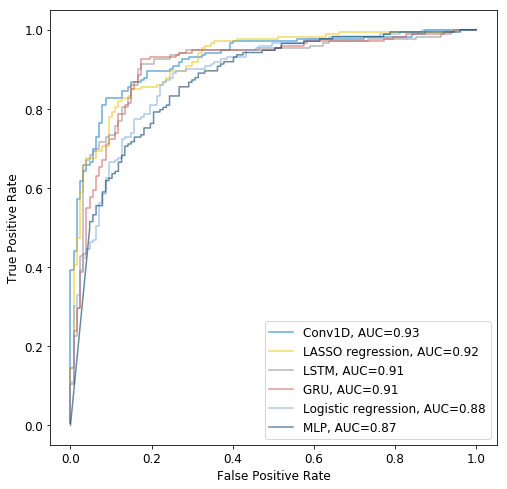

In [20]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from pandas import *

y_true = df_test['Group']

matplotlib.rcParams.update({'font.size': 12})

fpr_conv, tpr_conv, thresholds = metrics.roc_curve(y_true, df_test['prob_conv'], pos_label=1)
fpr_lasso, tpr_lasso, thresholds = metrics.roc_curve(y_true, df_test['prob_lasso'], pos_label=1)
fpr_lstm, tpr_lstm, thresholds = metrics.roc_curve(y_true, df_test['prob_lstm'], pos_label=1)
fpr_mlp, tpr_mlp, thresholds = metrics.roc_curve(y_true, df_test['prob_mlp'], pos_label=1)
fpr_gru, tpr_gru, thresholds = metrics.roc_curve(y_true, df_test['prob_gru'], pos_label=1)
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_true, df_test['prob_lr'], pos_label=1)

plt.figure(figsize=(8, 8)).clf()
plt.plot(fpr_conv,tpr_conv,label="Conv1D, AUC="+str(round(auc_conv,2)), color = '#0073C299')
plt.plot(fpr_lasso,tpr_lasso,label="LASSO regression, AUC="+str(round(auc_lasso, 2)), color = '#EFC00099')
plt.plot(fpr_lstm,tpr_lstm,label="LSTM, AUC="+str(round(auc_lstm,2)), color = '#86868699')
plt.plot(fpr_gru,tpr_gru,label="GRU, AUC="+str(round(auc_gru, 2)), color = '#CD534C99')
plt.plot(fpr_lr,tpr_lr,label="Logistic regression, AUC="+str(round(auc_lr,2)), color = '#7AA6DC99')
plt.plot(fpr_mlp,tpr_mlp,label="MLP, AUC="+str(round(auc_mlp,2)), color = '#003C6799')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)

path_figure_output = ### Insert directory for figures ###
plt.savefig(os.path.join(path_figure_output,'ROC curves.png'), dpi = 300)
plt.savefig('ROC_curves.eps', format = 'eps', dpi = 1000)

### 4J. Create Calibration Plot

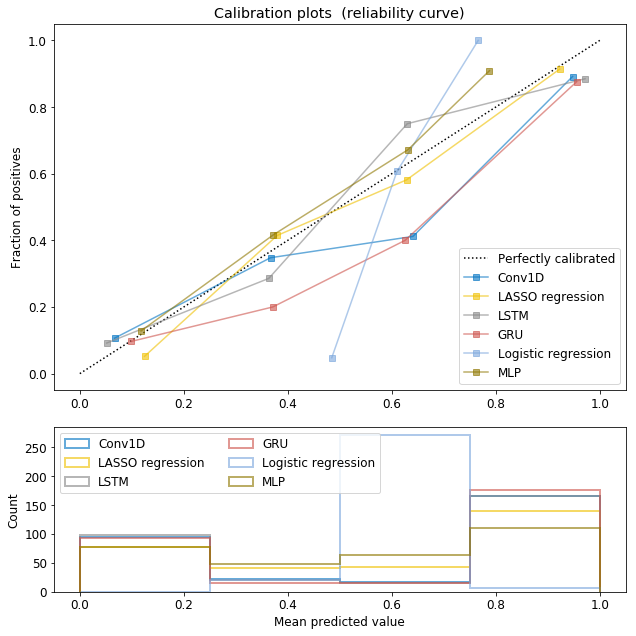

In [21]:
import matplotlib.pyplot as plt
import matplotlib
import os
from sklearn import metrics
from sklearn.calibration import calibration_curve
from pandas import *


plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

matplotlib.rcParams.update({'font.size': 12})

y_true = np.array(df_test['Group'])
prob_conv = np.array(df_test['prob_conv'])
prob_lasso = np.array(df_test['prob_lasso'])
prob_lstm = np.array(df_test['prob_lstm'])
prob_gru= np.array(df_test['prob_gru'])
prob_lr = np.array(df_test['prob_lr'])
prob_mlp = np.array(df_test['prob_mlp'])

for probs, name, color in [(prob_conv, 'Conv1D', '#0073C299'),
                    (prob_lasso, 'LASSO regression', '#EFC00099'),
                    (prob_lstm, 'LSTM', '#86868699'),
                    (prob_gru, 'GRU','#CD534C99'),
                    (prob_lr, 'Logistic regression','#7AA6DC99'),
                    (prob_mlp,'MLP','#8F770099')]:
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probs, n_bins=4)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (name, ), color = color)
    ax2.hist(probs, range=(0, 1), bins=4, label=name,histtype="step", lw=2, color = color)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left", ncol=2)

plt.tight_layout()

path_figure_output = ### Insert directory for figures ###

plt.savefig(os.path.join(path_figure_output, 'Calibration Plot.png'), dpi = 300)
plt.savefig('Calibration_Plot.eps', format = 'eps', dpi = 1000)